# Self-Driving Car Engineer Nanodegree


## Project: Advanced Lane Line Finding on the Road 

***

## Overview
In this project, overall goal is to create a software pipeline to identify the lane boundaries in a video recorded from a front-facing camera on a car. 

## Goals / Steps
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
***

## Import Packages

In [131]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip

## Camera Calibration

In [132]:
def camera_calibration(imgs,nx=9,ny=6):
    #prepare object points
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] #3d points in real world space
    imgpoints = [] #2d points in image plane
    
    for files in imgs:
        img = cv2.imread(files)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #find chessboard corners
        ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if len(objpoints)> 0:
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
        print('Camera Calibraion Successful!')
    else:
        ret,mtx,dist,rvecs,tvecs = None,None,None,None,None
        print('Camera Calibarion Unsuccessful!')
    return ret,mtx,dist,rvecs,tvecs

In [133]:
# Get calibration coefficient using calibration function and images
images = glob.glob('./camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = camera_calibration(images)

Camera Calibraion Successful!


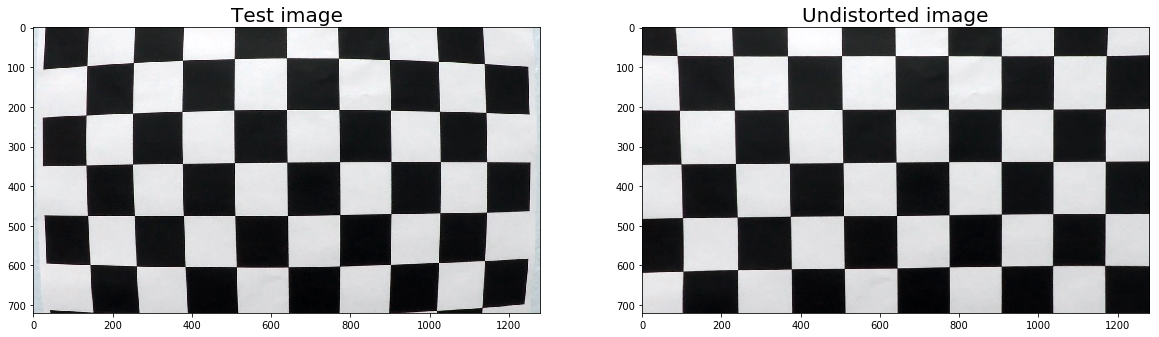

In [134]:
# Test image and undistorted image using calibration coefficient
test_img = cv2.imread('./camera_cal/calibration1.jpg')
undist_img = cv2.undistort(test_img,mtx,dist,None,mtx)

# helper function for ploting two images
def plt_images(img_1, title_1, img_2, title_2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=20)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=20)
    ax2.imshow(img_2)
    
plt_images(test_img, 'Test image', undist_img, 'Undistorted image')

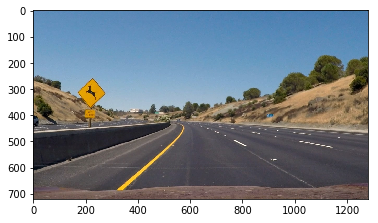

## Color transform & Gradient

In [153]:
def calculate_gradient(image,kernel_size):
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=kernel_size)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=kernel_size)
    return sobelx,sobely

def apply_mask(sobel,threshold):
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    binary = apply_non_scaled_mask(scaled_sobel,threshold)
    return binary

def apply_non_scaled_mask(sobel,threshold):
    binary = np.zeros_like(sobel)
    binary[(sobel>=threshold[0])&(sobel<=threshold[1])] = 1
    return binary
def abs_sobel_thresh(image,orient='x',threshold=(0,255)):
    
    if orient=='x':
        sobel = np.absolute(cv2.Sobel(image,cv2.CV_64F,1,0))
    elif orient =='y':
        sobel = np.absolute(cv2.Sobel(image,cv2.CV_64F,0,1))
    else:
        raise"Invalid value for orient:{}".format(orient)
    binary = apply_mask(sobel,threshold=threshold)
    return binary

def mag_thresh(img,sobel_ksize=3,threshold=(0,255)):
    sobelx, sobely = calculate_gradient(img,sobel_ksize)
    magxy = np.sqrt(sobelx**2+sobely**2)
    binary = apply_mask(magxy,threshold=threshold)
    return binary
                     
def dir_thresh(img,sobel_ksize=3,threshold=(0,np.pi/2)):
    sobelx, sobely = calculate_gradient(img,sobel_ksize)
    direction = np.arctan2(np.absolute(sobelx),np.absolute(sobely))
    binary = apply_non_scaled_mask(direction,threshold=threshold)
    return binary
                     

In [172]:
def edge_detection(image):
    
    #get R channel from BGR image
    #r_channel = image[:,:,2]
    #convert image to HLS space
    hls = cv2.cvtColor(image,cv2.COLOR_BGR2HLS).astype(np.float)
    #get s channel
    s_channel = hls[:,:,2]
    #S channel generally does good job on detecting lane edges. However, since 
    # R channel sometimes do better job on detecting white lanes, we will combine R and S channel
    # for detecting lane
    zeros = np.zeros((image.shape[:2]),dtype='uint8')
    #rs = cv2.merge([zeros,r_channel,s_channel])
    # get gradient mask
    abs_grad_x = abs_sobel_thresh(s_channel,orient='x',threshold=(50,150))
    abs_grad_y = abs_sobel_thresh(s_channel,orient='y',threshold=(50,150))
    mag_grad = mag_thresh(s_channel,threshold=(20,100))
    dir_grad = dir_thresh(s_channel,threshold=(0,np.pi/2))
    grad_mask = np.zeros_like(s_channel)
    grad_mask[((abs_grad_x==1)&(abs_grad_y==1))|((mag_grad==1)&(dir_grad==1))]=1
    color_mask= apply_non_scaled_mask(s_channel,threshold=(170,255))
    return s_channel, color_mask, grad_mask
def color_binary(image):
    rs,color_mask,grad_mask = edge_detection(image)
    binary = np.dstack((np.zeros_like(rs),color_mask,grad_mask))
    return binary

def combined_binary(image):
    rs,color_mask,grad_mask = edge_detection(image)
    binary = np.zeros_like(grad_mask)
    binary[(color_mask==1)|(grad_mask==1)]=1
    return binary
    

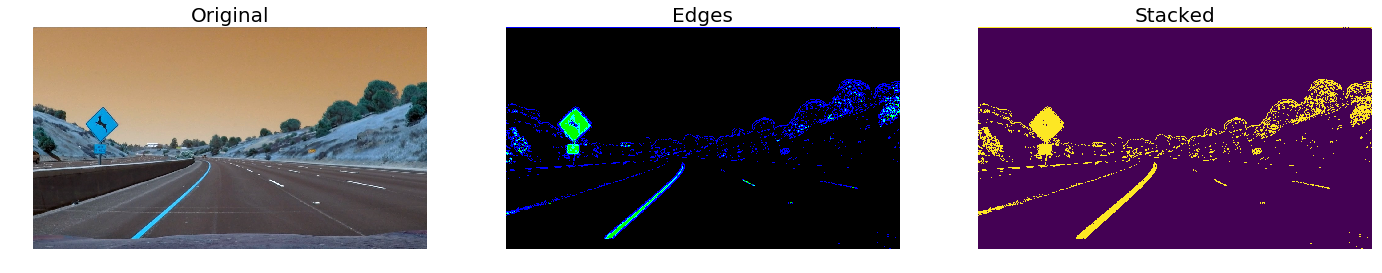

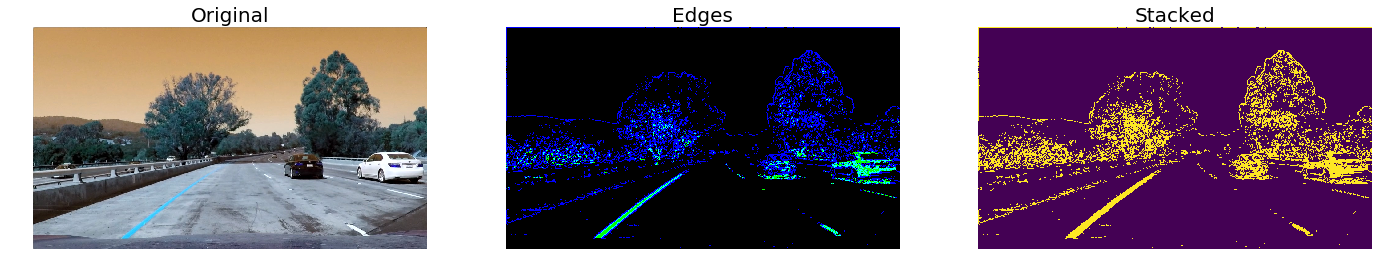

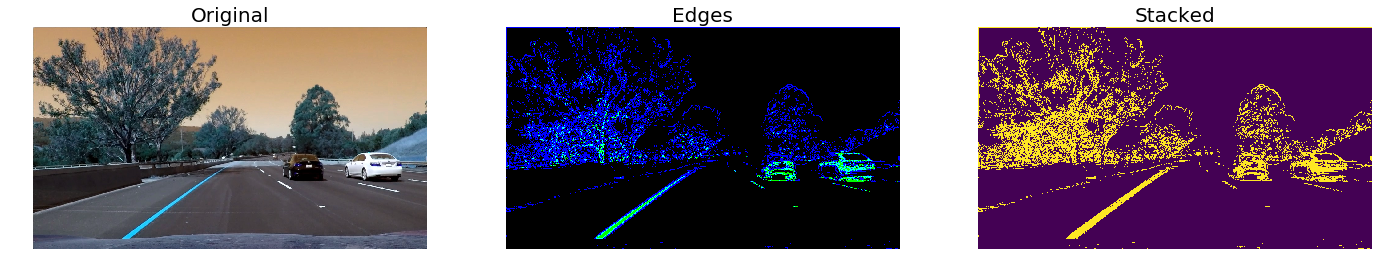

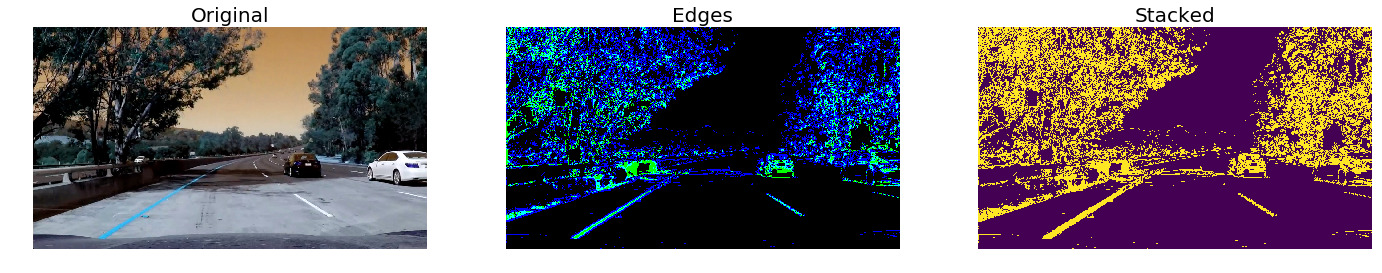

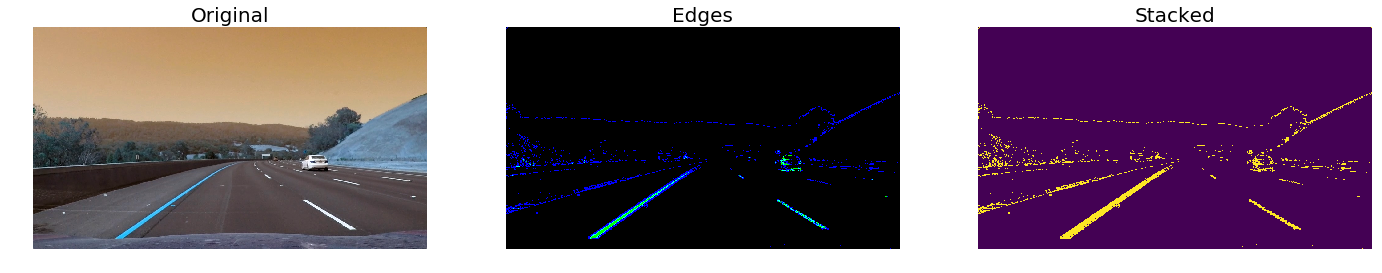

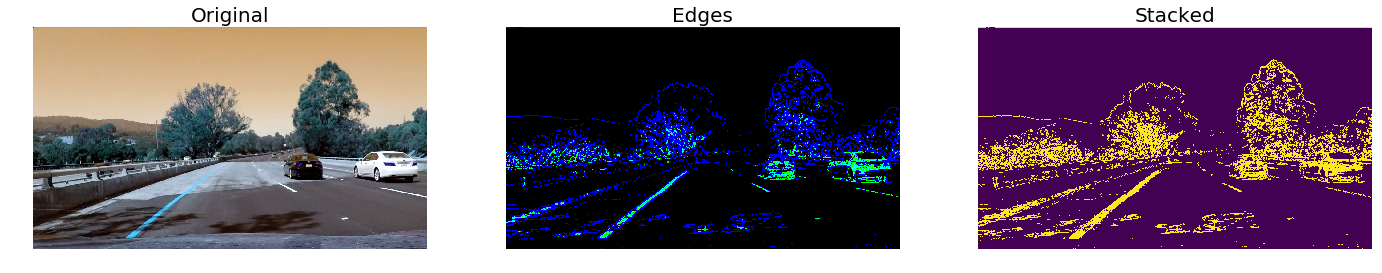

In [173]:
for image in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image)
    edges = color_binary(image)
    stack = combined_binary(image)

    f, (x1, x2, x3) = plt.subplots(1, 3, figsize=(24, 9))
    x1.axis('off')
    x1.imshow(image)
    x1.set_title('Original', fontsize=20)

    x2.axis('off')
    x2.imshow(edges)
    x2.set_title('Edges', fontsize=20)
    
    x3.axis('off')
    x3.imshow(stack)
    x3.set_title('Stacked', fontsize=20)

In [150]:
image = cv2.imread('test_images/test2.jpg')
edges = color_binary(image)
stack = combined_binary(image)

In [140]:
print(image.shape)

(720, 1280, 3)


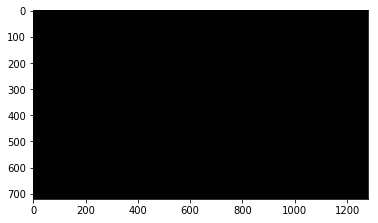

In [128]:
plt.imshow(stack)